<a href="https://colab.research.google.com/github/Ana-Paula-23/EDA_2025/blob/main/bitacora_properati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ydata_profiling scikit-learn folium openpyxl spacy transformers torch pandas numpy regex unidecode

In [2]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 62.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Importación de librerías
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import re

In [4]:
# Montar Google Drive sobre Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Base desarrollo

Levanto la base de desarrollo

In [5]:
# Levantamos .csv
df = pd.read_csv("/content/drive/MyDrive/EDA_2025/bd_desarrollo.csv",sep=';')

# Vista inicial
df.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
0,556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,"-58,4423994000","-34,5736231000",Argentina,Capital Federal,Colegiales,...,2.0,NaN,NaN,USD,NaN,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
1,192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,"-58,4304928000","-34,6066200000",Argentina,Capital Federal,Almagro,...,2.0,77.0,67.0,USD,NaN,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta,235500.0
2,238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,"-58,4917602500","-34,5741233800",Argentina,Capital Federal,Villa Urquiza,...,1.0,60.0,55.0,USD,NaN,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta,175000.0
3,521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,"-58,4299830000","-34,6072250000",Argentina,Capital Federal,Almagro,...,1.0,66.0,64.0,USD,NaN,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
4,383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,"-58,4207800000","-34,6086400000",Argentina,Capital Federal,Almagro,...,1.0,55.0,55.0,USD,NaN,Depto.tipo casa de 3 ambientes en Venta en Alm...,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0


# Base test

Levanto la base test y dejo los filtros que corresponden: Venta y USD

Con los filtros nos quedamos con 60.319 registros de 85.528 (70.5%)

In [6]:
# Levantamos .csv
df_test = pd.read_csv("/content/drive/MyDrive/EDA_2025/bd_test.csv",sep=';')

# Filter for operation_type = "Venta" and currency = "USD"
df_test = df_test[(df_test['operation_type'] == 'Venta') & (df_test['currency'] == 'USD')]

# Vista inicial
df_test.head()

# Tamaño del dataset
print("Filas:", df_test.shape[0])
print("Columnas:", df_test.shape[1])

# Tipos de variables
df_test.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df_test.describe().T

Filas: 60319
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               60319 non-null  int64  
 1   ad_type          60319 non-null  object 
 2   start_date       60319 non-null  object 
 3   end_date         60319 non-null  object 
 4   created_on       60319 non-null  object 
 5   lat              51736 non-null  object 
 6   lon              51807 non-null  object 
 7   l1               60319 non-null  object 
 8   l2               60319 non-null  object 
 9   l3               57619 non-null  object 
 10  l4               20764 non-null  object 
 11  l5               437 non-null    object 
 12  l6               0 non-null      float64
 13  rooms            46044 non-null  float64
 14  bedrooms         38620 non-null  float64
 15  bathrooms        56172 non-null  float64
 16  surface_total    34537 non-null  floa

,count,mean,std,min,25%,50%,75%,max
id,60319.0,494547.015236,294605.476442,9.0,237974.5,492133.0,752855.5,999986.0
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,46044.0,2.999392,1.493668,1.0,2.0,3.0,4.0,35.0
bedrooms,38620.0,2.205256,1.374264,0.0,1.0,2.0,3.0,77.0
bathrooms,56172.0,1.699993,1.022667,1.0,1.0,1.0,2.0,16.0
surface_total,34537.0,242.325477,1601.531668,0.0,52.0,88.0,200.0,100000.0
surface_covered,36650.0,128.991241,618.994208,1.0,47.0,75.0,150.0,58000.0
price,60319.0,235745.780036,339352.329129,0.0,99000.0,155000.0,260000.0,26653528.0


Transformación de las variables

In [7]:
# Convert date columns to datetime objects
df_test['start_date'] = pd.to_datetime(df_test['start_date'], format='%Y-%m-%d', errors='coerce')
df_test['end_date'] = pd.to_datetime(df_test['end_date'], format='%Y-%m-%d', errors='coerce')
df_test['created_on'] = pd.to_datetime(df_test['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df_test[['start_date', 'end_date', 'created_on']].info())

df_test['start_date'].dt.strftime('%Y/%m/%d').head()
df_test['end_date'].dt.strftime('%Y/%m/%d').head()
df_test['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df_test['lat'] = pd.to_numeric(df_test['lat'].str.replace(',', '.'), errors='coerce')
df_test['lon'] = pd.to_numeric(df_test['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df_test[['lat', 'lon']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  60319 non-null  datetime64[ns]
 1   end_date    44344 non-null  datetime64[ns]
 2   created_on  60319 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 1.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     51736 non-null  float64
 1   lon     51807 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB
None


In [ ]:
# Generate the EDA report
#profile = ProfileReport(df_test, title="My EDA Report")
#profile

In [ ]:
# Save the report to an HTML file
# profile.to_file("eda_report_df_test.html")

# EDA - Base desarrollo

In [8]:
# Tamaño del dataset
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])

# Tipos de variables
df.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df.describe().T

Filas: 879294
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               879294 non-null  int64  
 1   ad_type          879294 non-null  object 
 2   start_date       879294 non-null  object 
 3   end_date         879294 non-null  object 
 4   created_on       879294 non-null  object 
 5   lat              743531 non-null  object 
 6   lon              744354 non-null  object 
 7   l1               879294 non-null  object 
 8   l2               879294 non-null  object 
 9   l3               827305 non-null  object 
 10  l4               185112 non-null  object 
 11  l5               3781 non-null    object 
 12  l6               0 non-null       float64
 13  rooms            432009 non-null  float64
 14  bedrooms         334687 non-null  float64
 15  bathrooms        681546 non-null  float64
 16  surface_tot

,count,mean,std,min,25%,50%,75%,max
id,879294.0,502302.326894,2.882041e+05,1.0,253101.25,503737.5,752416.75,1.000000e+06
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,432009.0,2.866357,1.701833e+00,1.0,2.00,3.0,4.00,4.000000e+01
bedrooms,334687.0,2.084473,2.751976e+00,-13.0,1.00,2.0,3.00,9.000000e+02
bathrooms,681546.0,1.696844,1.071229e+00,1.0,1.00,1.0,2.00,2.000000e+01
surface_total,384422.0,511.374284,4.244219e+03,-200.0,50.00,95.0,277.00,2.000000e+05
surface_covered,373844.0,637.453502,7.981026e+04,-170.0,45.00,75.0,155.00,2.700000e+07
price,838214.0,295447.634787,5.905478e+06,0.0,39000.00,95000.0,205000.00,3.100000e+09


Transformación del tipo de variable

In [9]:
# Convert date columns to datetime objects
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df['created_on'] = pd.to_datetime(df['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df[['start_date', 'end_date', 'created_on']].info())

df['start_date'].dt.strftime('%Y/%m/%d').head()
df['end_date'].dt.strftime('%Y/%m/%d').head()
df['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df['lat'] = pd.to_numeric(df['lat'].str.replace(',', '.'), errors='coerce')
df['lon'] = pd.to_numeric(df['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df[['lat', 'lon']].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_date  879294 non-null  datetime64[ns]
 1   end_date    711369 non-null  datetime64[ns]
 2   created_on  879294 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 20.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     743531 non-null  float64
 1   lon     744354 non-null  float64
dtypes: float64(2)
memory usage: 13.4 MB
None


Sólo para chequear que hayan cambiado el tipo de variables

In [10]:
# Tamaño del dataset
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])

# Tipos de variables
df.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df.describe().T

Filas: 879294
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               879294 non-null  int64         
 1   ad_type          879294 non-null  object        
 2   start_date       879294 non-null  datetime64[ns]
 3   end_date         711369 non-null  datetime64[ns]
 4   created_on       879294 non-null  datetime64[ns]
 5   lat              743531 non-null  float64       
 6   lon              744354 non-null  float64       
 7   l1               879294 non-null  object        
 8   l2               879294 non-null  object        
 9   l3               827305 non-null  object        
 10  l4               185112 non-null  object        
 11  l5               3781 non-null    object        
 12  l6               0 non-null       float64       
 13  rooms            432009 non-null  float64      

,count,mean,min,25%,50%,75%,max,std
id,879294.0,502302.326894,1.0,253101.25,503737.5,752416.75,1000000.0,288204.143672
start_date,879294,2020-01-30 00:31:33.580987136,2019-07-04 00:00:00,2019-11-13 00:00:00,2020-02-22 00:00:00,2020-04-10 00:00:00,2020-07-27 00:00:00,NaN
end_date,711369,2020-03-13 03:02:02.169506816,2019-07-04 00:00:00,2020-01-17 00:00:00,2020-03-29 00:00:00,2020-05-15 00:00:00,2020-09-25 00:00:00,NaN
created_on,879294,2020-01-30 00:31:33.580987136,2019-07-04 00:00:00,2019-11-13 00:00:00,2020-02-22 00:00:00,2020-04-10 00:00:00,2020-07-27 00:00:00,NaN
lat,743531.0,-59.364581,-180.0,-58.875928,-58.44394,-57.947404,-35.045025,2.854415
lon,744354.0,-34.817495,-54.842464,-35.149529,-34.612371,-34.431146,85.051129,3.254305
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,432009.0,2.866357,1.0,2.0,3.0,4.0,40.0,1.701833
bedrooms,334687.0,2.084473,-13.0,1.0,2.0,3.0,900.0,2.751976
bathrooms,681546.0,1.696844,1.0,1.0,1.0,2.0,20.0,1.071229


Reporte EDA base original

In [ ]:
# Generate the EDA report
#profile = ProfileReport(df, title="EDA db_desarrollo")
#
## Save the report to an HTML file
#profile.to_file("eda_report_df_desarrollo.html")

In [22]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df[col].value_counts()
    relative_frequencies = df[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
2.0                118344               27.393874
3.0                109046               25.241604
1.0                 84800               19.629221
4.0                 65682               15.203850
5.0                 29186                6.755878
6.0                 12770                2.955957
7.0                  5780                1.337935
8.0                  2802                0.648598
10.0                 1487                0.344206
9.0                  1049                0.242819
12.0                  251                0.058101
11.0                  195                0.045138
13.0                   95                0.021990
15.0                   89                0.020601
14.0                   73                0.016898
20.0                   68                0.015740
16.0                   52                0.012037
30.0                   

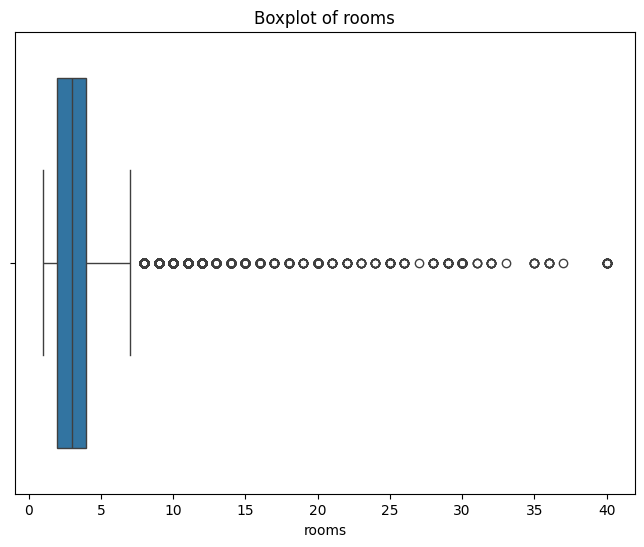

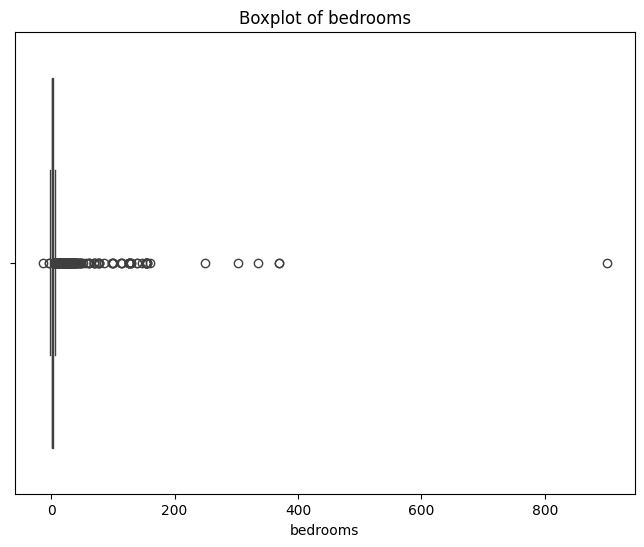

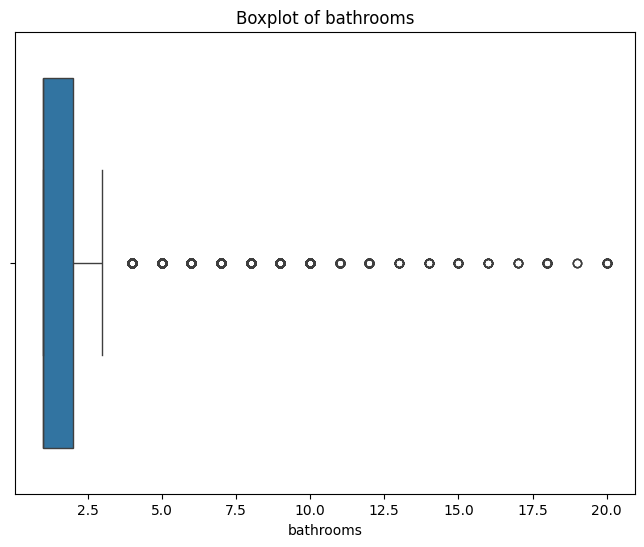

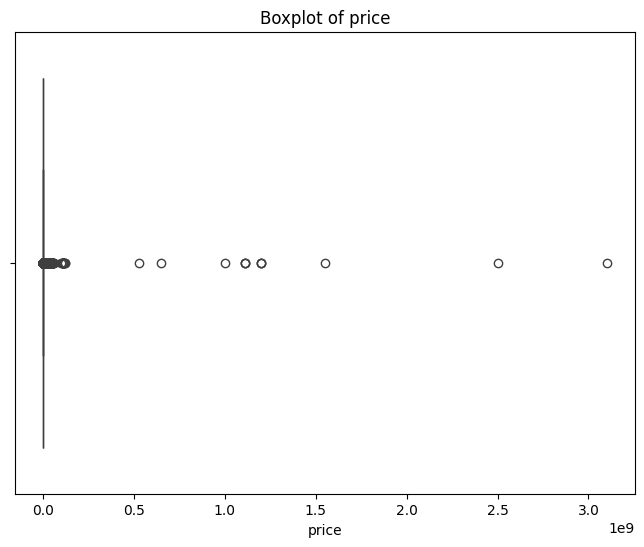

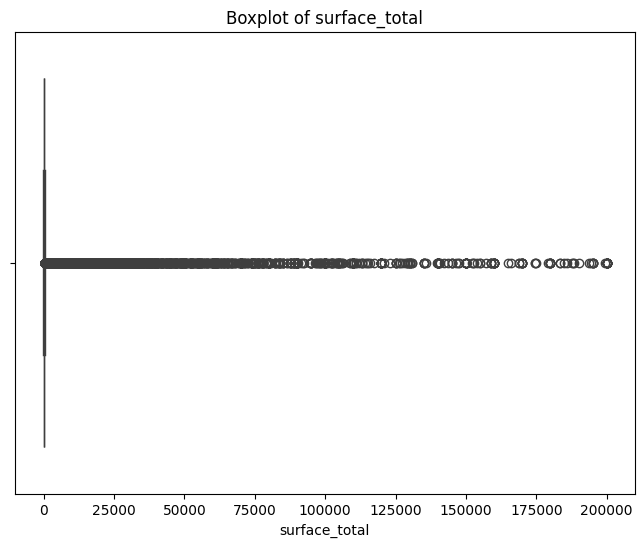

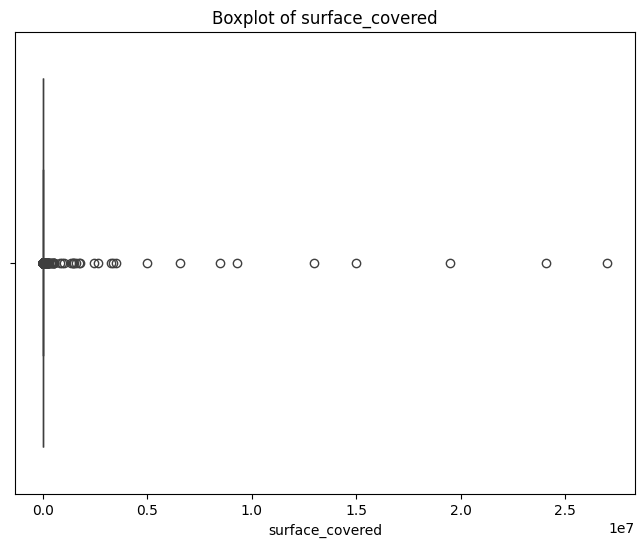

In [13]:
# Select specified numeric columns for visualizations
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

# Generate boxplots for selected numeric variables
for col in numeric_cols_selected:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Filtros

Originalmete la base train tiene 879.294 registros y 25 variables. Después de aplicar los filtros correspondientes nos quedamos con 289.254 filas (32.9% de los registros)



### operation_type = Ventas

In [15]:
df_ventas = df[df['operation_type'] == 'Venta']

### l1 = Argentina

In [16]:
df_ventas = df_ventas[df_ventas['l1'] == 'Argentina']

### l2 = Capital Federal, Bs.As. G.B.A. Zona Norte, Bs.As. G.B.A. Zona Sur, Bs.As. G.B.A. Zona Oeste, Santa Fe, Córdoba

In [17]:
region = ['Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Oeste','Santa Fe','Córdoba']
df_ventas = df_ventas[df_ventas['l2'].isin(region)]

### property_type = Departamento, Casa, PH, Casa de campo

In [18]:
tipos_validos = ['Departamento', 'Casa', 'PH', 'Casa de campo']
df_ventas_sin_otros = df_ventas[df_ventas['property_type'].isin(tipos_validos)]

In [19]:
# Tamaño del dataset
print("Filas:", df_ventas_sin_otros.shape[0])
print("Columnas:", df_ventas_sin_otros.shape[1])

# Tipos de variables
df_ventas_sin_otros.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df_ventas_sin_otros.describe().T

Filas: 289254
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
Index: 289254 entries, 0 to 879288
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               289254 non-null  int64         
 1   ad_type          289254 non-null  object        
 2   start_date       289254 non-null  datetime64[ns]
 3   end_date         204067 non-null  datetime64[ns]
 4   created_on       289254 non-null  datetime64[ns]
 5   lat              250826 non-null  float64       
 6   lon              251219 non-null  float64       
 7   l1               289254 non-null  object        
 8   l2               289254 non-null  object        
 9   l3               278635 non-null  object        
 10  l4               85346 non-null   object        
 11  l5               1818 non-null    object        
 12  l6               0 non-null       float64       
 13  rooms            238759 non-null  float64       
 14

,count,mean,min,25%,50%,75%,max,std
id,289254.0,476287.586723,5.0,214765.25,465419.5,735407.75,999995.0,293210.494054
start_date,289254,2020-01-20 10:11:40.898172672,2019-07-04 00:00:00,2019-10-24 00:00:00,2020-01-27 00:00:00,2020-04-13 00:00:00,2020-07-27 00:00:00,NaN
end_date,204067,2020-03-12 19:28:27.939058944,2019-07-05 00:00:00,2019-12-20 00:00:00,2020-04-01 00:00:00,2020-06-25 00:00:00,2020-09-25 00:00:00,NaN
created_on,289254,2020-01-20 10:11:40.898172672,2019-07-04 00:00:00,2019-10-24 00:00:00,2020-01-27 00:00:00,2020-04-13 00:00:00,2020-07-27 00:00:00,NaN
lat,250826.0,-59.279703,-180.0,-58.836317,-58.488919,-58.414656,-54.13333,1.769699
lon,251219.0,-34.097965,-53.788249,-34.639811,-34.590055,-34.391687,85.051129,1.11263
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,238759.0,2.989613,1.0,2.0,3.0,4.0,40.0,1.598677
bedrooms,192925.0,2.160684,-13.0,1.0,2.0,3.0,900.0,2.676177
bathrooms,270572.0,1.677169,1.0,1.0,1.0,2.0,20.0,1.013373


### Tabla de frecuencias (absolutas, relativas y acumulada porcentual) incluyendo los NA

In [33]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type', 'l2','currency']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts(dropna=False)
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True, dropna=False) * 100
    cumulative_relative_frequencies = relative_frequencies.cumsum() # Calculate cumulative relative frequencies
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
3.0                 65054               22.490268
2.0                 64543               22.313607
NaN                 50495               17.456976
4.0                 41795               14.449238
1.0                 35825               12.385308
5.0                 17702                6.119881
6.0                  7337                2.536525
7.0                  3211                1.110097
8.0                  1510                0.522033
10.0                  719                0.248570
9.0                   593                0.205010
12.0                  137                0.047363
11.0                  105                0.036300
15.0                   43                0.014866
13.0                   39                0.013483
14.0                   35                0.012100
20.0                   20                0.006914
16.0                   

### Tabla de frecuencias (absolutas, relativas y acumulada porcentual) SIN NA

In [35]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type', 'l2','currency']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts(dropna=True) # Include NA counts
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True, dropna=True) * 100 # Include NA percentage
    cumulative_relative_frequencies = relative_frequencies.cumsum() # Calculate cumulative relative frequencies
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies,
        'Cumulative Relative Frequency (%)': cumulative_relative_frequencies # Add cumulative frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)  \
rooms                                               
3.0                 65054               27.246722   
2.0                 64543               27.032698   
4.0                 41795               17.505099   
1.0                 35825               15.004670   
5.0                 17702                7.414171   
6.0                  7337                3.072973   
7.0                  3211                1.344871   
8.0                  1510                0.632437   
10.0                  719                0.301140   
9.0                   593                0.248368   
12.0                  137                0.057380   
11.0                  105                0.043977   
15.0                   43                0.018010   
13.0                   39                0.016334   
14.0                   35                0.014659   
20.0                   20                0.008377   
16.0               

### Observaciones
- rooms:  17.5% de NA
- bedrooms: 33% de NA
- bathrooms: 6.5% de NA
- price: 4.7% de NA
- surface_total: 39.3% de NA
- surface_covered: 33.6% de NA
- currency: 5% de NA y 2.7% de ARG

## Detección de outliers

### Anlalisis univariado

#### Boxplot por tipo de propiedad

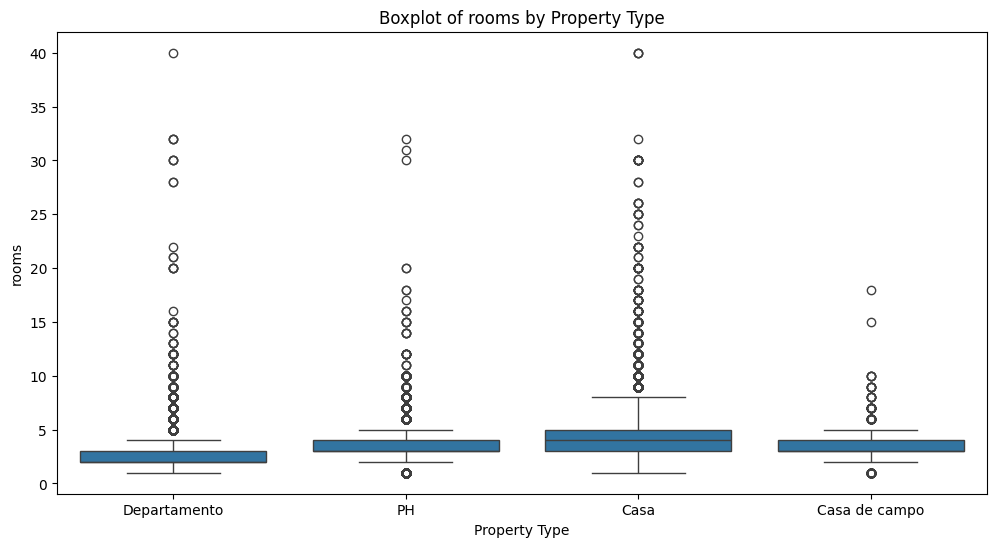

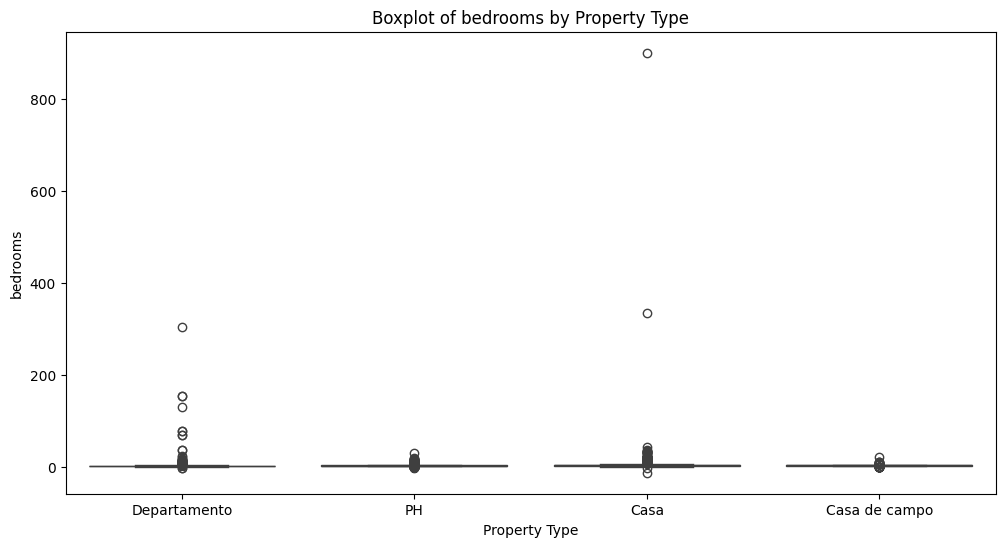

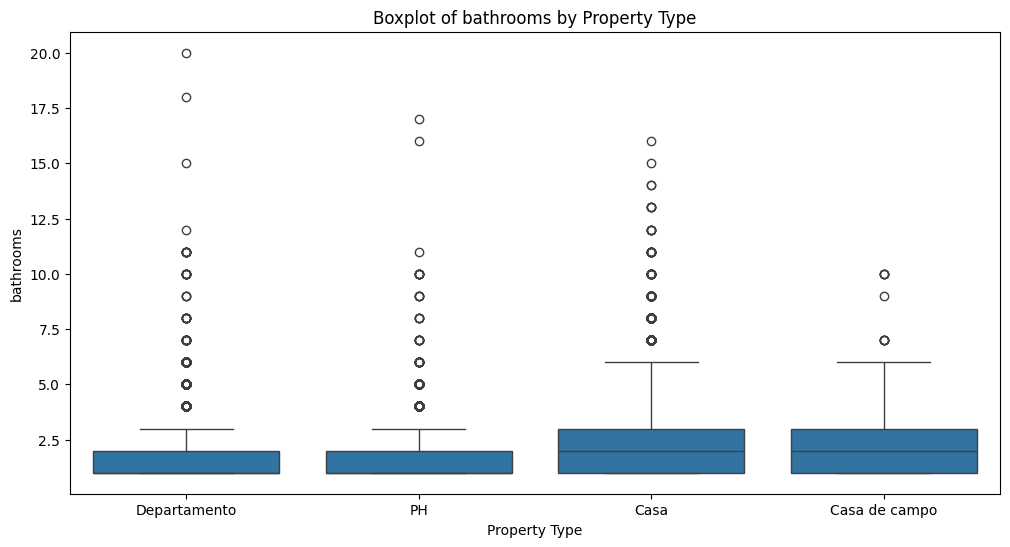

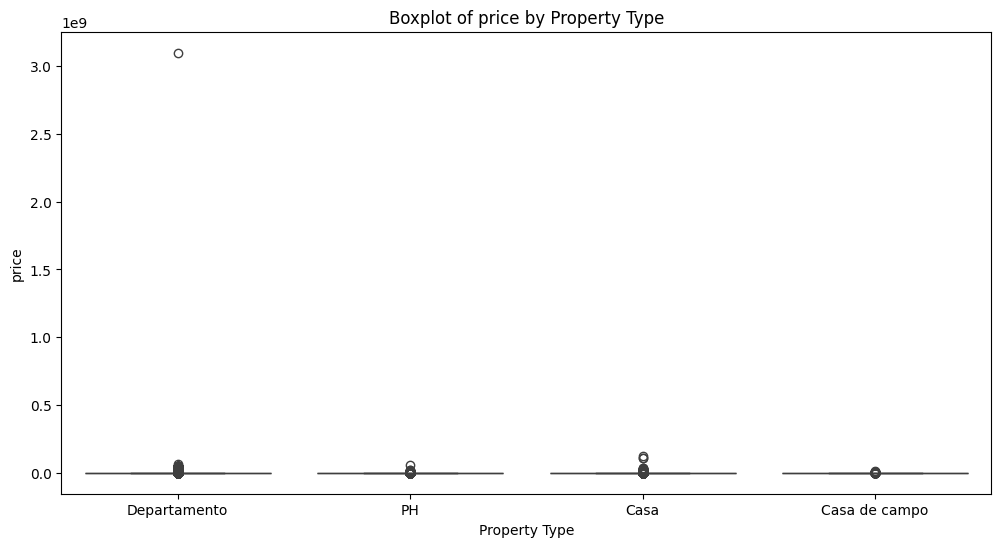

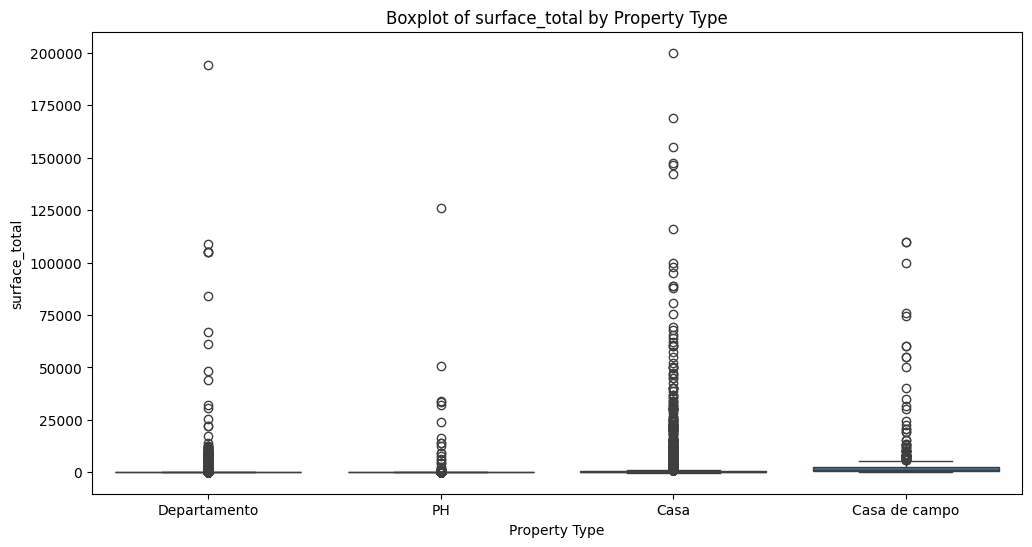

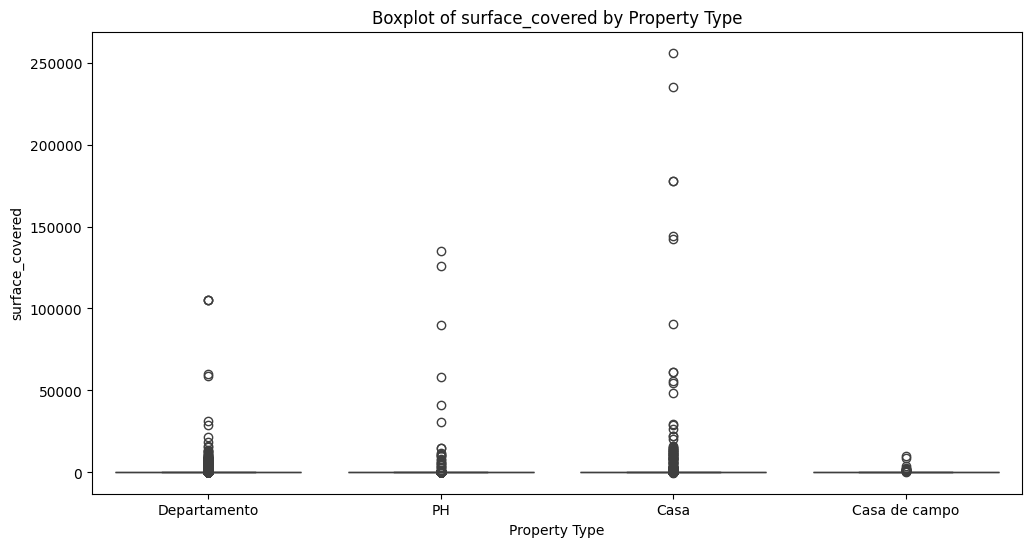

In [37]:
# Select specified numeric columns for visualizations
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

# Generate boxplots for selected numeric variables, grouped by property_type
for col in numeric_cols_selected:
    plt.figure(figsize=(12, 6)) # Adjust figure size for better readability
    sns.boxplot(x='property_type', y=df_ventas_sin_otros[col], data=df_ventas_sin_otros)
    plt.title(f'Boxplot of {col} by Property Type')
    plt.xlabel('Property Type')
    plt.ylabel(col)
    plt.show()

#### IQR

In [44]:
# Detect outliers using IQR for selected numeric variables and add flag columns
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

for col in numeric_cols_selected:
    print(f"Detecting outliers for: {col}")

    # Calculate Q1, Q3, and IQR
    Q1 = df_ventas_sin_otros[col].quantile(0.25)
    Q3 = df_ventas_sin_otros[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers and create a flag column
    outlier_flag_col = f'{col}_outlier_iqr'
    df_ventas_sin_otros[outlier_flag_col] = ((df_ventas_sin_otros[col] < lower_bound) | (df_ventas_sin_otros[col] > upper_bound)).astype(int)

    print(f"Number of outliers in {col}: {df_ventas_sin_otros[outlier_flag_col].sum()}")
    print(f"Percentage of outliers in {col}: {df_ventas_sin_otros[outlier_flag_col].sum() / len(df_ventas_sin_otros) * 100:.2f}%")
    print(f"Outlier values in {col} (first 10):")
    print(df_ventas_sin_otros.loc[df_ventas_sin_otros[outlier_flag_col] == 1, col].head(10))
    print("\n" + "="*50 + "\n")

Detecting outliers for: rooms
Number of outliers in rooms: 3292
Percentage of outliers in rooms: 1.14%
Outlier values in rooms (first 10):
4546     9.0
5152    10.0
5393    10.0
5394     9.0
5397     8.0
5398     8.0
5975    10.0
5986    12.0
6009     8.0
6491     9.0
Name: rooms, dtype: float64


Detecting outliers for: bedrooms
Number of outliers in bedrooms: 696
Percentage of outliers in bedrooms: 0.24%
Outlier values in bedrooms (first 10):
5164      7.0
5430      7.0
9302      7.0
9303      7.0
9499     10.0
11960    -3.0
13275    36.0
13278    70.0
15779     8.0
15864     8.0
Name: bedrooms, dtype: float64


Detecting outliers for: bathrooms
Number of outliers in bathrooms: 16703
Percentage of outliers in bathrooms: 5.77%
Outlier values in bathrooms (first 10):
267     4.0
466     4.0
790     6.0
1027    4.0
1484    4.0
1619    4.0
1696    4.0
1865    4.0
2055    4.0
2250    6.0
Name: bathrooms, dtype: float64


Detecting outliers for: price
Number of outliers in price: 24865
Per

/tmp/ipython-input-354908688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_sin_otros[outlier_flag_col] = ((df_ventas_sin_otros[col] < lower_bound) | (df_ventas_sin_otros[col] > upper_bound)).astype(int)
/tmp/ipython-input-354908688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_sin_otros[outlier_flag_col] = ((df_ventas_sin_otros[col] < lower_bound) | (df_ventas_sin_otros[col] > upper_bound)).astype(int)
/tmp/ipython-input-354908688.py:18: SettingWithCopyWarning: 
A value is 

#### Z-score

In [47]:
# Detect outliers using Z-score for selected numeric variables and add flag columns

# Create a clean copy of the DataFrame to work with
df_clean_zscore = df_ventas_sin_otros.copy()

numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

for col in numeric_cols_selected:
    print(f"Detecting outliers for: {col} using Z-score")

    # Calculate the mean and standard deviation
    mean = df_clean_zscore[col].mean()
    std = df_clean_zscore[col].std()

    # Calculate the Z-score for each value
    df_clean_zscore[f'{col}_zscore'] = (df_clean_zscore[col] - mean) / std

    # Define a threshold for outlier detection (e.g., Z-score > 3 or < -3)
    zscore_threshold = 3

    # Identify outliers and create a flag column
    outlier_flag_col = f'{col}_outlier_zscore'
    df_clean_zscore[outlier_flag_col] = ((df_clean_zscore[f'{col}_zscore'].abs() > zscore_threshold)).astype(int)


    print(f"Number of outliers in {col}: {df_clean_zscore[outlier_flag_col].sum()}")
    print(f"Percentage of outliers in {col}: {df_clean_zscore[outlier_flag_col].sum() / len(df_clean_zscore) * 100:.2f}%")
    print(f"Outlier values in {col} (first 10):")
    # Display original values for outliers
    print(df_clean_zscore.loc[df_clean_zscore[outlier_flag_col] == 1, col].head(10))
    print("\n" + "="*50 + "\n")

# Now df_clean_zscore has the original data plus the Z-score and outlier flag columns
# You can display df_clean_zscore.head() to see the new columns
# display(df_clean_zscore.head())

Detecting outliers for: rooms using Z-score
Number of outliers in rooms: 3292
Percentage of outliers in rooms: 1.14%
Outlier values in rooms (first 10):
4546     9.0
5152    10.0
5393    10.0
5394     9.0
5397     8.0
5398     8.0
5975    10.0
5986    12.0
6009     8.0
6491     9.0
Name: rooms, dtype: float64


Detecting outliers for: bedrooms using Z-score
Number of outliers in bedrooms: 108
Percentage of outliers in bedrooms: 0.04%
Outlier values in bedrooms (first 10):
13275    36.0
13278    70.0
18223    12.0
19421    20.0
31408    11.0
43904    20.0
48299    34.0
48300    15.0
54182    18.0
55039    11.0
Name: bedrooms, dtype: float64


Detecting outliers for: bathrooms using Z-score
Number of outliers in bathrooms: 5160
Percentage of outliers in bathrooms: 1.78%
Outlier values in bathrooms (first 10):
790     6.0
2250    6.0
2282    5.0
5117    6.0
5131    5.0
5152    5.0
5157    5.0
5404    5.0
5413    8.0
5414    6.0
Name: bathrooms, dtype: float64


Detecting outliers for: pri

#### MAD

In [51]:
# Detect outliers using MAD for selected numeric variables and add flag columns

# Create a clean copy of the DataFrame to work with
df_clean_mad = df_ventas_sin_otros.copy()

numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

for col in numeric_cols_selected:
    print(f"Detecting outliers for: {col} using MAD")

    # Calculate the median
    median = df_clean_mad[col].median()

    # Calculate the Median Absolute Deviation (MAD)
    mad = (df_clean_mad[col] - median).abs().median()

    # Define a threshold for outlier detection (e.g., values more than 3 MAD from the median)
    mad_threshold = 3

    # Identify outliers and create a flag column
    outlier_flag_col = f'{col}_outlier_mad'
    # Using a small epsilon to avoid division by zero if mad is 0
    df_clean_mad[outlier_flag_col] = ((df_clean_mad[col] - median).abs() / (mad + 1e-9) > mad_threshold).astype(int)


    print(f"Number of outliers in {col}: {df_clean_mad[outlier_flag_col].sum()}")
    print(f"Percentage of outliers in {col}: {df_clean_mad[outlier_flag_col].sum() / len(df_clean_mad) * 100:.2f}%")
    print(f"Outlier values in {col} (first 10):")
    # Display original values for outliers
    print(df_clean_mad.loc[df_clean_mad[outlier_flag_col] == 1, col].head(10))
    print("\n" + "="*50 + "\n")

# The df_clean_mad DataFrame now has the MAD outlier flag columns
# You can display df_clean_mad.head() to see the new columns
# display(df_clean_mad.head())

Detecting outliers for: rooms using MAD
Number of outliers in rooms: 6503
Percentage of outliers in rooms: 2.25%
Outlier values in rooms (first 10):
4546     9.0
4548     7.0
5152    10.0
5164     7.0
5201     7.0
5393    10.0
5394     9.0
5397     8.0
5398     8.0
5960     7.0
Name: rooms, dtype: float64


Detecting outliers for: bedrooms using MAD
Number of outliers in bedrooms: 1824
Percentage of outliers in bedrooms: 0.63%
Outlier values in bedrooms (first 10):
5156      6.0
5157      6.0
5164      7.0
5430      7.0
5960      6.0
8922      6.0
9302      7.0
9303      7.0
9499     10.0
11960    -3.0
Name: bedrooms, dtype: float64


Detecting outliers for: bathrooms using MAD
Number of outliers in bathrooms: 112484
Percentage of outliers in bathrooms: 38.89%
Outlier values in bathrooms (first 10):
0     2.0
1     2.0
6     2.0
7     2.0
8     2.0
11    2.0
14    2.0
15    3.0
16    2.0
17    2.0
Name: bathrooms, dtype: float64


Detecting outliers for: price using MAD
Number of outli

### Análisis multivariado

#### Análisis de clustering: Distancia de Mahalanobis

In [54]:
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

# Select the specified numeric features
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']
df_numeric = df_ventas_sin_otros[numeric_cols_selected].copy()

# Handle missing values by filling with the mean (a simple approach)
# More sophisticated methods like imputation can be considered depending on the data
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols_selected)

# Calculate the covariance matrix and its inverse
covariance_matrix = df_scaled.cov()
inv_covariance_matrix = inv(covariance_matrix)

# Calculate Mahalanobis distance for each data point
mahalanobis_distances = []
for i in range(len(df_scaled)):
    x = df_scaled.iloc[i, :].values
    maha_distance = mahalanobis(x, df_scaled.mean().values, inv_covariance_matrix)
    mahalanobis_distances.append(maha_distance)

df_ventas_sin_otros['mahalanobis_distance'] = mahalanobis_distances

# Identify outliers using a threshold (e.g., based on chi-squared distribution)
# A common approach is to use the chi-squared distribution with degrees of freedom equal to the number of features
from scipy.stats import chi2

# Set the significance level (e.g., 0.001 for a strict threshold)
alpha = 0.001
degrees_of_freedom = len(numeric_cols_selected)
threshold = chi2.ppf(1 - alpha, degrees_of_freedom)

df_ventas_sin_otros['multivariate_outlier_mahalanobis'] = (df_ventas_sin_otros['mahalanobis_distance'] > threshold).astype(int)

print(f"Number of multivariate outliers detected: {df_ventas_sin_otros['multivariate_outlier_mahalanobis'].sum()}")
print(f"Percentage of multivariate outliers: {df_ventas_sin_otros['multivariate_outlier_mahalanobis'].sum() / len(df_ventas_sin_otros) * 100:.2f}%")

# Display some of the identified multivariate outliers
print("\nExamples of multivariate outliers:")
display(df_ventas_sin_otros[df_ventas_sin_otros['multivariate_outlier_mahalanobis'] == 1].head())

Number of multivariate outliers detected: 120
Percentage of multivariate outliers: 0.04%

Examples of multivariate outliers:


/tmp/ipython-input-1732063426.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_sin_otros['mahalanobis_distance'] = mahalanobis_distances
/tmp/ipython-input-1732063426.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_sin_otros['multivariate_outlier_mahalanobis'] = (df_ventas_sin_otros['mahalanobis_distance'] > threshold).astype(int)


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,operation_type,price,rooms_outlier_iqr,bedrooms_outlier_iqr,bathrooms_outlier_iqr,price_outlier_iqr,surface_total_outlier_iqr,surface_covered_outlier_iqr,mahalanobis_distance,multivariate_outlier_mahalanobis
4426,311924,Propiedad,2020-07-16,2020-08-24,2020-07-16,-68.468140,-33.081030,Argentina,Capital Federal,NaN,...,Venta,145000.0,0,0,0,0,1,1,24.579352,1
6648,2561,Propiedad,2019-10-15,2020-02-07,2019-10-15,-64.175543,-31.422578,Argentina,Córdoba,Córdoba,...,Venta,NaN,0,0,0,0,0,1,237.576202,1
13278,10079,Propiedad,2019-10-03,2019-10-08,2019-10-03,-58.450655,-34.600705,Argentina,Capital Federal,NaN,...,Venta,125000.0,0,1,0,0,0,0,32.573586,1
17357,14911,Propiedad,2019-11-25,2020-08-30,2019-11-25,-58.646104,-34.435997,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,...,Venta,490000.0,0,0,0,0,0,1,217.993725,1
18381,16134,Propiedad,2019-12-23,2020-06-27,2019-12-23,-59.654056,-29.169775,Argentina,Santa Fe,Reconquista,...,Venta,NaN,1,0,0,0,0,1,165.112476,1


#### Local Outlier Factor (LOF)

In [55]:
from sklearn.neighbors import LocalOutlierFactor

# Select the specified numeric features
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']
df_numeric_lof = df_ventas_sin_otros[numeric_cols_selected].copy()

# Handle missing values by filling with the mean (a simple approach)
# LOF can handle some missing values, but imputation is generally recommended
df_numeric_lof.fillna(df_numeric_lof.mean(), inplace=True)

# Scale the data
scaler = StandardScaler()
df_scaled_lof = scaler.fit_transform(df_numeric_lof)

# Fit the Local Outlier Factor model
# n_neighbors: number of neighbors to consider for the local density
# contamination: the proportion of outliers in the data set
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
y_pred = lof.fit_predict(df_scaled_lof)

# The LOF algorithm assigns a score to each data point.
# Negative scores are outliers, and the more negative, the more likely it is an outlier.
# y_pred will be -1 for outliers and 1 for inliers.

# Add the LOF outlier flag to the original DataFrame (on a copy)
# We'll use a copy to avoid SettingWithCopyWarning
df_clean_lof = df_ventas_sin_otros.copy()
df_clean_lof['multivariate_outlier_lof'] = (y_pred == -1).astype(int)

print(f"Number of multivariate outliers detected by LOF: {df_clean_lof['multivariate_outlier_lof'].sum()}")
print(f"Percentage of multivariate outliers detected by LOF: {df_clean_lof['multivariate_outlier_lof'].sum() / len(df_clean_lof) * 100:.2f}%")

# Display some of the identified multivariate outliers by LOF
print("\nExamples of multivariate outliers detected by LOF:")
display(df_clean_lof[df_clean_lof['multivariate_outlier_lof'] == 1].head())

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Number of multivariate outliers detected by LOF: 34626
Percentage of multivariate outliers detected by LOF: 11.97%

Examples of multivariate outliers detected by LOF:


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,price,rooms_outlier_iqr,bedrooms_outlier_iqr,bathrooms_outlier_iqr,price_outlier_iqr,surface_total_outlier_iqr,surface_covered_outlier_iqr,mahalanobis_distance,multivariate_outlier_mahalanobis,multivariate_outlier_lof
0,556713,Propiedad,2019-11-29,NaT,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,...,259000.0,0,0,0,0,0,0,0.397181,0,1
14,884685,Propiedad,2020-04-02,2020-04-03,2020-04-02,NaN,NaN,Argentina,Capital Federal,Villa Urquiza,...,208000.0,0,0,0,0,0,0,0.422225,0,1
17,195954,Propiedad,2020-05-19,2020-08-07,2020-05-19,-58.411296,-34.592484,Argentina,Capital Federal,Palermo,...,190000.0,0,0,0,0,0,0,0.423020,0,1
33,261147,Propiedad,2020-07-24,NaT,2020-07-24,-58.516836,-34.659837,Argentina,Capital Federal,Mataderos,...,315000.0,0,0,0,0,0,0,0.396631,0,1
35,171679,Propiedad,2020-05-12,2020-05-20,2020-05-12,-58.441660,-34.607250,Argentina,Capital Federal,Caballito,...,91000.0,0,0,0,0,0,0,0.857119,0,1


#### Isolation Forest

In [56]:
from sklearn.ensemble import IsolationForest

# Select the specified numeric features
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']
df_numeric_iso = df_ventas_sin_otros[numeric_cols_selected].copy()

# Handle missing values by filling with the mean (a simple approach)
# Isolation Forest can handle some missing values, but imputation is generally recommended
df_numeric_iso.fillna(df_numeric_iso.mean(), inplace=True)

# Scale the data
scaler = StandardScaler()
df_scaled_iso = scaler.fit_transform(df_numeric_iso)

# Fit the Isolation Forest model
# n_estimators: the number of base estimators in the ensemble
# contamination: the proportion of outliers in the data set
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
y_pred_iso = iso_forest.fit_predict(df_scaled_iso)

# The Isolation Forest algorithm assigns a score to each data point.
# Negative scores indicate outliers (-1), while positive scores indicate inliers (1).

# Add the Isolation Forest outlier flag to the original DataFrame (on a copy)
# We'll use a copy to avoid SettingWithCopyWarning
df_clean_iso = df_ventas_sin_otros.copy()
df_clean_iso['multivariate_outlier_isolation_forest'] = (y_pred_iso == -1).astype(int)

print(f"Number of multivariate outliers detected by Isolation Forest: {df_clean_iso['multivariate_outlier_isolation_forest'].sum()}")
print(f"Percentage of multivariate outliers detected by Isolation Forest: {df_clean_iso['multivariate_outlier_isolation_forest'].sum() / len(df_clean_iso) * 100:.2f}%")

# Display some of the identified multivariate outliers by Isolation Forest
print("\nExamples of multivariate outliers detected by Isolation Forest:")
display(df_clean_iso[df_clean_iso['multivariate_outlier_isolation_forest'] == 1].head())

Number of multivariate outliers detected by Isolation Forest: 25934
Percentage of multivariate outliers detected by Isolation Forest: 8.97%

Examples of multivariate outliers detected by Isolation Forest:


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,price,rooms_outlier_iqr,bedrooms_outlier_iqr,bathrooms_outlier_iqr,price_outlier_iqr,surface_total_outlier_iqr,surface_covered_outlier_iqr,mahalanobis_distance,multivariate_outlier_mahalanobis,multivariate_outlier_isolation_forest
267,357046,Propiedad,2019-11-06,2019-12-23,2019-11-06,-58.363594,-34.604894,Argentina,Capital Federal,Puerto Madero,...,1200000.0,0,0,1,1,0,0,2.751947,0,1
466,431584,Propiedad,2019-10-24,2019-12-23,2019-10-24,-58.361708,-34.610426,Argentina,Capital Federal,Puerto Madero,...,1189997.0,0,0,1,1,0,0,2.751338,0,1
790,541810,Propiedad,2020-05-15,2020-09-24,2020-05-15,NaN,NaN,Argentina,Capital Federal,Caballito,...,200600.0,0,0,1,0,0,0,5.585318,0,1
1518,440062,Propiedad,2019-11-27,2020-02-27,2019-11-27,-58.055189,-34.860019,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,56000.0,0,0,0,0,0,0,1.768992,0,1
1619,332333,Propiedad,2020-05-13,NaT,2020-05-13,-58.361513,-34.613261,Argentina,Capital Federal,Puerto Madero,...,1250000.0,0,0,1,1,0,0,2.753677,0,1


In [ ]:
#df_ventas_sin_otros.to_excel('df_ventas_sin_otros.xlsx', index=False)

/tmp/ipython-input-13482292.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_sin_otros['description'] = df_ventas_sin_otros['description'].apply(clean_text)


### Corrplot

<Axes: >

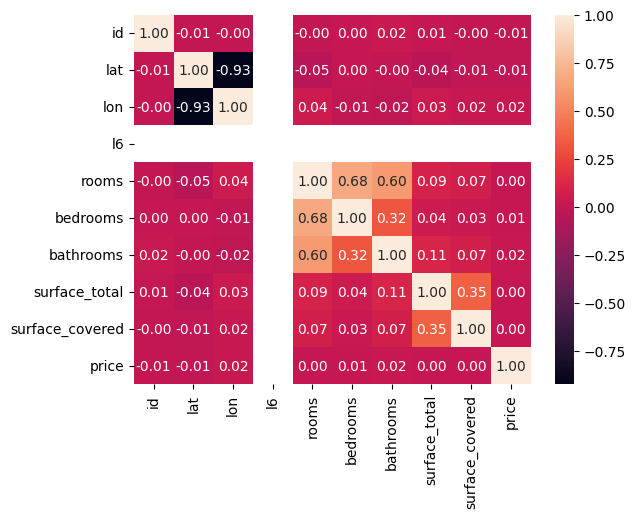

In [21]:
sns.heatmap(df_ventas_sin_otros.select_dtypes(include='number').corr(), annot=True, fmt='.2f')

In [24]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts()
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
3.0                 65054               27.246722
2.0                 64543               27.032698
4.0                 41795               17.505099
1.0                 35825               15.004670
5.0                 17702                7.414171
6.0                  7337                3.072973
7.0                  3211                1.344871
8.0                  1510                0.632437
10.0                  719                0.301140
9.0                   593                0.248368
12.0                  137                0.057380
11.0                  105                0.043977
15.0                   43                0.018010
13.0                   39                0.016334
14.0                   35                0.014659
20.0                   20                0.008377
16.0                   17                0.007120
30.0                   

## Filtro opción 2

### property_type incluyendo "Otro"

Son 377.716 de 879.294 registros (42.9%)

In [23]:
tipos_validos1 = ['Departamento', 'Casa', 'PH', 'Casa de campo','Otro']
df_ventas_con_otros = df_ventas[df_ventas['property_type'].isin(tipos_validos1)]

# Tamaño del dataset
print("Filas:", df_ventas_con_otros.shape[0])
print("Columnas:", df_ventas_con_otros.shape[1])

# Tipos de variables
df_ventas_con_otros.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df_ventas_con_otros.describe().T

Filas: 377716
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
Index: 377716 entries, 0 to 879293
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               377716 non-null  int64         
 1   ad_type          377716 non-null  object        
 2   start_date       377716 non-null  datetime64[ns]
 3   end_date         289786 non-null  datetime64[ns]
 4   created_on       377716 non-null  datetime64[ns]
 5   lat              311832 non-null  float64       
 6   lon              312291 non-null  float64       
 7   l1               377716 non-null  object        
 8   l2               377716 non-null  object        
 9   l3               350072 non-null  object        
 10  l4               99830 non-null   object        
 11  l5               1871 non-null    object        
 12  l6               0 non-null       float64       
 13  rooms            240884 non-null  float64       
 14

,count,mean,min,25%,50%,75%,max,std
id,377716.0,521017.678557,5.0,264313.75,542292.5,770648.75,1000000.0,291119.987025
start_date,377716,2020-02-01 22:21:27.672219648,2019-07-04 00:00:00,2019-11-15 00:00:00,2020-02-25 00:00:00,2020-04-11 00:00:00,2020-07-27 00:00:00,NaN
end_date,289786,2020-03-21 22:40:52.838991616,2019-07-05 00:00:00,2020-01-21 00:00:00,2020-04-27 00:00:00,2020-05-30 00:00:00,2020-09-25 00:00:00,NaN
created_on,377716,2020-02-01 22:21:27.672219648,2019-07-04 00:00:00,2019-11-15 00:00:00,2020-02-25 00:00:00,2020-04-11 00:00:00,2020-07-27 00:00:00,NaN
lat,311832.0,-59.453892,-180.0,-60.630062,-58.506514,-58.414645,-53.828578,1.95489
lon,312291.0,-34.009009,-53.788249,-34.644699,-34.591006,-33.000386,85.051129,1.227035
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,240884.0,2.995928,1.0,2.0,3.0,4.0,40.0,1.62085
bedrooms,194634.0,2.164082,-13.0,1.0,2.0,3.0,900.0,2.690722
bathrooms,329135.0,1.678366,1.0,1.0,1.0,2.0,20.0,1.025658


### Tabla de frecuencias (absolutas, relativas y acumulada porcentual) incluyendo los NA

In [31]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type', 'l2','currency']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_con_otros[col].value_counts(dropna=False)
    relative_frequencies = df_ventas_con_otros[col].value_counts(normalize=True, dropna=False) * 100
    cumulative_relative_frequencies = relative_frequencies.cumsum() # Calculate cumulative relative frequencies
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
NaN                136832               36.226159
3.0                 65451               17.328098
2.0                 64710               17.131919
4.0                 42162               11.162355
1.0                 36430                9.644813
5.0                 17946                4.751189
6.0                  7440                1.969734
7.0                  3303                0.874467
8.0                  1538                0.407184
10.0                  768                0.203327
9.0                   614                0.162556
12.0                  149                0.039448
11.0                  109                0.028858
15.0                   50                0.013237
13.0                   42                0.011119
14.0                   39                0.010325
20.0                   26                0.006883
16.0                   

### Tabla de frecuencias (absolutas, relativas y acumulada porcentual) SIN NA

In [29]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered', 'property_type', 'l2','currency']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_con_otros[col].value_counts(dropna=True) # Include NA counts
    relative_frequencies = df_ventas_con_otros[col].value_counts(normalize=True, dropna=True) * 100 # Include NA percentage
    cumulative_relative_frequencies = relative_frequencies.cumsum() # Calculate cumulative relative frequencies
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies,
        'Cumulative Relative Frequency (%)': cumulative_relative_frequencies # Add cumulative frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)  \
rooms                                               
3.0                 65451               27.171170   
2.0                 64710               26.863553   
4.0                 42162               17.503031   
1.0                 36430               15.123462   
5.0                 17946                7.450059   
6.0                  7440                3.088624   
7.0                  3303                1.371199   
8.0                  1538                0.638482   
10.0                  768                0.318826   
9.0                   614                0.254894   
12.0                  149                0.061855   
11.0                  109                0.045250   
15.0                   50                0.020757   
13.0                   42                0.017436   
14.0                   39                0.016190   
20.0                   26                0.010794   
16.0               

#### Observaciones

- Con todos los filtros el tipo de propiedad "otros representa el 23.4% de los registros.
- rooms: 36.2% de NA
- bedrooms: 48.5% de NA
- bathrooms: 12.9 de NA
- price: 3.8% de NA
- surface_total: 52.7% de NA
- surface_coveres: 48.3% de NA
- currency: 4.1% de NA y 3.8% de ARS

### Corrplot

<Axes: >

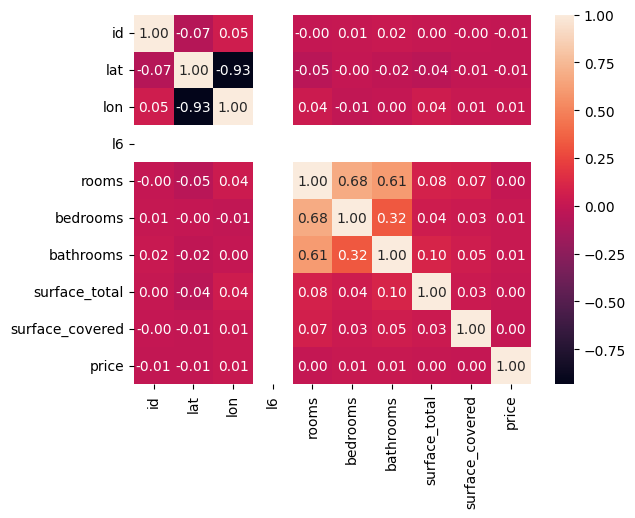

In [32]:
sns.heatmap(df_ventas_con_otros.select_dtypes(include='number').corr(), annot=True, fmt='.2f')

## Cosas que llaman la atención, para revisar


### Surface_total < surface_covered

In [ ]:
# Filter for rows where surface_total is less than surface_covered
df_surface_anomaly = df_ventas_sin_otros[df_ventas_sin_otros['surface_total'] < df_ventas_sin_otros['surface_covered']]

# Display the ids of these rows
print("IDs donde surface_total < surface_covered:")
print("Lista ID:",df_surface_anomaly['id'].tolist())
print("Total de casos:",df_surface_anomaly['id'].count())

IDs donde surface_total < surface_covered:
Lista ID: [438415, 219825, 747468, 410793, 293814, 309123, 95756, 638567, 410420, 452194, 616563, 364097, 49556, 42246, 410641, 525171, 317809, 581710, 73076, 943057, 16046, 831288, 626673, 853681, 231516, 364333, 306460, 147166, 111659, 500054, 500098, 397893, 2378, 2381, 3011, 3265, 3488, 3834, 3836, 3837, 3838, 3909, 3936, 3937, 3943, 5107, 5109, 5110, 5114, 5119, 5120, 5121, 5140, 5141, 5146, 5147, 5148, 5149, 5150, 5189, 5190, 5191, 5202, 5246, 5247, 5249, 5261, 5745, 7044, 7586, 7587, 7876, 7881, 8372, 8608, 8609, 8616, 8790, 9646, 9790, 9791, 9792, 9793, 10640, 10769, 10995, 12090, 12094, 12473, 14843, 14911, 15038, 15329, 15589, 15777, 16158, 16564, 16565, 16566, 16972, 17118, 17143, 17188, 17198, 17246, 17258, 17507, 17962, 17969, 18558, 18576, 18629, 18645, 18647, 18726, 18878, 18885, 18903, 19355, 19411, 20329, 20374, 20554, 20555, 20690, 20716, 20845, 20853, 20889, 20963, 20967, 20976, 21052, 21475, 22210, 22212, 22213, 22215, 2288

Hipótesis: Están al revés.
Procedimiento: tomar una muestra de 50 casos y ver la descripción.

In [ ]:
# Take a sample of 50 cases from df_surface_anomaly
sample_surface_anomaly = df_surface_anomaly.sample(n=50, random_state=42) # Using random_state for reproducibility

sample_surface_anomaly.to_excel('surface_total_menor_surface_covered2.xlsx', index=False)

- Las Casa quintas están incluidas en el análisis?
- Qué pasas con las publicaciones que incluyen varias propiedades? Ej: más de un departamento en el mismo edificio o una casa con local.
- ¿Hay que hacer algún tratamiento de las propiedades que se repiten? Ej: 16564, 16565, 16566.

## Surface_total y surface_covered negativos o vacíos

In [ ]:
df_ventas_surface = df_ventas_sin_otros[
    (df_ventas_sin_otros['surface_total'] <= 10) |
    (df_ventas_sin_otros['surface_covered'] <= 10) |
    (df_ventas_sin_otros['surface_total'].isna()) |
    (df_ventas_sin_otros['surface_covered'].isna())
]

lista_surface = df_ventas_surface['id'].tolist()
len(lista_surface)

120709

In [ ]:
df_ventas_sin_otros.groupby('property_type').describe().T

property_type           Casa  Casa de campo    Departamento             PH
id    count          92450.0          881.0        176633.0        19290.0
      mean     490976.643061  538592.707151   468825.137941  471374.193572
      min                6.0         3715.0           100.0            5.0
      25%          227706.25       282668.0        209371.0      215022.25
      50%           485647.5       578149.0        455530.0       445306.5
...                      ...            ...             ...            ...
price 25%           130000.0       120000.0         83000.0        90000.0
      50%           220000.0       180000.0        125000.0       140000.0
      75%           368000.0       295750.0        215000.0       215000.0
      max        123123321.0     11500000.0    3100000000.0     55000000.0
      std      892953.972788   625861.18685  7714264.376382  597823.018403

[104 rows x 4 columns]

### Surface_total y surface_covered negativos

In [ ]:
df_ventas_surface_neg = df_ventas_sin_otros[
    (df_ventas_sin_otros['surface_total'] <= 10) |
    (df_ventas_sin_otros['surface_covered'] <= 10)
]

lista_surface_neg = df_ventas_surface_neg['id'].tolist()
len(lista_surface_neg)

466

Revisión manual de estos casos

In [ ]:
df_surface_neg_filtered = df_ventas_sin_otros[df_ventas_sin_otros['id'].isin(lista_surface_neg)]

df_surface_neg_filtered.to_excel('df_surface_neg_filtered_1.xlsx', index=False)

### Surface_total y surface_covered vacíos

In [ ]:
df_ventas_surface_na = df_ventas_sin_otros[
    (df_ventas_sin_otros['surface_total'].isna()) |
    (df_ventas_sin_otros['surface_covered'].isna())
]

lista_surface_na = df_ventas_surface_na['id'].tolist()
len(lista_surface_na)

120571

In [ ]:
ids_interes = lista_surface

df_filtrado = df_ventas[df_ventas['id'].isin(ids_interes)][['id','surface_total', 'surface_covered', 'description']]

# Define a function to clean the text by removing illegal characters
def clean_text(text):
    if isinstance(text, str):
        # Remove illegal characters (control characters, etc.)
        illegal_chars = re.compile(r'[\x00-\x08\x0b\x0c\x0e-\x1f]')
        text = illegal_chars.sub('', text)
        return text
    return text

# Apply the cleaning function to the 'description' column
df_filtrado['description'] = df_filtrado['description'].apply(clean_text)

df_filtrado.to_excel('datos_filtrados_superficie_2.xlsx', index=False)

df_filtrado

,id,surface_total,surface_covered,description
0,556713,NaN,NaN,"Sup total por escritura: 96,47 m2 (cubiertos: ..."
7,76927,NaN,NaN,"Forma de pago: 35% de anticipo, saldo en cuota..."
10,758087,NaN,NaN,VENTA DE DEPARTAMENTO 3 AMBIENTES EN Caballito...
26,168773,NaN,NaN,Venta de Duplex 2 dormitorios Villa Elisa&nbsp...
33,261147,NaN,NaN,Venta de Departamento 3 AMBIENTES en Mataderos...
...,...,...,...,...
879271,999972,NaN,NaN,Espectacular casa ubicada en barrio Causana a ...
879285,999992,NaN,NaN,Barbaro Vende Casa de 5 Dormitorio(s) de 3x...
879287,999994,NaN,NaN,Chalet en 2 plantas en Florida OestePB: Hall -...
879288,999995,NaN,NaN,AMPLIA CASA 7 AMBIENTES PERFECTA UBICACIÓN PL...


In [ ]:
nlp = spacy.load("es_core_news_sm")

In [ ]:
# ---------------------------
# 3. Funciones de extracción
# ---------------------------

def extract_lote_size(text):
    """Busca patrones tipo 10x15 (ancho x largo)."""
    if not isinstance(text, str):
        return None, None, None
    match = re.search(r'(\d{2,3})\s*[xX]\s*(\d{2,3})', text)
    if match:
        ancho, largo = map(int, match.groups())
        superficie = ancho * largo
        return ancho, largo, superficie
    return None, None, None

def extract_sup_cub(text):
    """Busca superficie cubierta (SUP. CUB / superficie cubierta)."""
    if not isinstance(text, str):
        return None
    match = re.search(
        r'(?:SUP\.?\s*CUB\.?|superficie cubierta)\s*([\d.,]+)',
        text,
        re.IGNORECASE
    )
    if match:
        return float(match.group(1).replace(",", "."))
    return None

def extract_ambientes(text):
    """Detecta cantidad de ambientes."""
    if not isinstance(text, str):
        return None
    match = re.search(r'(\d+)\s*ambiente[s]?', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

def extract_banos(text):
    """Detecta cantidad de baños."""
    if not isinstance(text, str):
        return None
    match = re.search(r'(\d+)\s*bañ[oa]s?', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

def extract_dormitorios(text):
    """Detecta cantidad de dormitorios."""
    if not isinstance(text, str):
        return None
    match = re.search(r'(\d+)\s*dormitorio[s]?', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

def extract_cochera(text):
    """Detecta cochera o garage."""
    if not isinstance(text, str):
        return 0  # Assuming 0 if description is not a string
    match = re.search(r'cochera|garage', text, re.IGNORECASE)
    if match:
        if "doble" in text.lower():
            return 2
        return 1
    return 0

def extract_pileta(text):
    """Detecta si menciona pileta."""
    if not isinstance(text, str):
        return 0 # Assuming 0 if description is not a string
    return 1 if re.search(r'pileta', text, re.IGNORECASE) else 0

# ---------------------------
# 4. Aplicar pipeline NLP
# ---------------------------

def process_descriptions(df, col="description"):
    # Convert non-string values to string or handle appropriately before processing
    df[col] = df[col].astype(str)
    # Procesamiento básico con spaCy (lemmatización, tokens, etc.)
    df["clean_text"] = df[col].apply(lambda x: " ".join([t.lemma_ for t in nlp(x)]))

    # Aplicar reglas personalizadas
    df[["lote_ancho", "lote_largo", "lote_superficie"]] = df[col].apply(
        lambda x: pd.Series(extract_lote_size(x))
    )
    df["sup_cubierta"] = df[col].apply(extract_sup_cub)
    df["ambientes"] = df[col].apply(extract_ambientes)
    df["banos"] = df[col].apply(extract_banos)
    df["dormitorios"] = df[col].apply(extract_dormitorios)
    df["cocheras"] = df[col].apply(extract_cochera)
    df["pileta"] = df[col].apply(extract_pileta)


    return df

# ---------------------------
# 5. Ejecutar
# ---------------------------

df_resultado = process_descriptions(df_ventas)

print(df_resultado)

ValueError: could not convert string to float: '.'

# Limpieza inicial

In [ ]:
df_clean = df_ventas_sin_otros.copy()